In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
df_customers = pd.read_csv("F:/Kaggle/E-Commerce-Analysis/olist_customers_dataset.csv")
df_sellers = pd.read_csv("F:/Kaggle/E-commerce-Analysis/olist_sellers_dataset.csv")
df_order_reviews = pd.read_csv("F:/kaggle/E-commerce-Analysis/olist_order_reviews_dataset.csv")
df_order_items = pd.read_csv("F:/kaggle/E-commerce-Analysis/olist_order_items_dataset.csv")
df_products = pd.read_csv("F:/kaggle/E-commerce-Analysis/olist_products_dataset.csv")
df_geolocation = pd.read_csv("F:/kaggle/E-commerce-Analysis/olist_geolocation_dataset.csv")
df_product_category_name_translation = pd.read_csv("F:/kaggle/E-commerce-Analysis/product_category_name_translation.csv")
df_orders = pd.read_csv("F:/kaggle/E-commerce-Analysis/olist_orders_dataset.csv")
df_order_payments = pd.read_csv("F:/kaggle/E-commerce-Analysis/olist_order_payments_dataset.csv")

In [3]:
## print the columns of all dataframes
print(
f"'The columns of olist_customers are :-  ',{df_customers.columns} \n \
'The columns of olist_sellers are :-  ',{df_sellers.columns} \n \
'The columns of olist_order_reviews are :-  ',{df_order_reviews.columns} \n \
'The columns of olist_order_items are :-  ',{df_order_items.columns} \n \
'The columns of olist_products are :-  ',{df_products.columns} \n \
'The columns of olist_geolocation are :-  ',{df_geolocation.columns} \n \
'The columns of product_category_name_translation are :-  ',{df_product_category_name_translation.columns} \n \
'The columns of olist_orders_dataset are :-  ',{df_orders.columns} \n \
'The columns of olist_order_payments are :-  ',{df_order_payments.columns}"
)

'The columns of olist_customers are :-  ',Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object') 
 'The columns of olist_sellers are :-  ',Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object') 
 'The columns of olist_order_reviews are :-  ',Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object') 
 'The columns of olist_order_items are :-  ',Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object') 
 'The columns of olist_products are :-  ',Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
  

"At our system each order is assigned to a unique customer_id. This means that the same customer will get different ids for different orders. The purpose of having a customer_unique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with."

使用 customer_unique_id 辨識消費者是否為新舊客。


In [25]:
#合併 df_orders, df_order_payments 兩個檔案取得訂單資訊：訂單id、消費者id、訂單時間、訂單金額、結帳方式...
#消費者可以把一張訂單拆成不同付費方式(credit card + voucher)，所以 df_order_payments 筆數比較多
order_data = pd.merge(df_orders, df_order_payments, on="order_id")


In [7]:
#1: 計算2016/09/04 - 2018/10/17 月營收
print(order_data["order_purchase_timestamp"].max())
print(order_data["order_purchase_timestamp"].min())

2018-10-17 17:30:18
2016-09-04 21:15:19


In [71]:
order_data["order_purchase_timestamp"] = pd.to_datetime(order_data["order_purchase_timestamp"])
order_data["order_purchase_y"] = order_data["order_purchase_timestamp"].dt.year.astype(int)
order_data["order_purchase_m"] = order_data["order_purchase_timestamp"].dt.month.astype(int)
order_data["order_purchase_y_m"] = order_data["order_purchase_y"].astype(str) + "-" + order_data["order_purchase_m"].astype(str)
order_data["order_purchase_date"] = pd.to_datetime(order_data["order_purchase_y_m"])
print(order_data.info())
#order_data


<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       103886 non-null  object        
 1   customer_id                    103886 non-null  object        
 2   order_status                   103886 non-null  object        
 3   order_purchase_timestamp       103886 non-null  datetime64[ns]
 4   order_approved_at              103711 non-null  object        
 5   order_delivered_carrier_date   101998 non-null  object        
 6   order_delivered_customer_date  100754 non-null  object        
 7   order_estimated_delivery_date  103886 non-null  object        
 8   payment_sequential             103886 non-null  int64         
 9   payment_type                   103886 non-null  object        
 10  payment_installments           103886 non-null  int64         
 11  

In [86]:
#扣掉 order_status = cancel 的欄位
revenue = order_data[order_data["order_status"] == "delivered"].groupby(["order_purchase_y","order_purchase_m"]).agg('sum').sort_values(by=["order_purchase_y","order_purchase_m"]).reset_index()
revenue["order_purchase_y_m"] = revenue["order_purchase_y"].astype(str) + "-" + revenue["order_purchase_m"].astype(str)
revenue

,order_purchase_y,order_purchase_m,payment_sequential,payment_installments,payment_value,order_purchase_y_m
0,2016,10,316,985,46566.71,2016-10
1,2016,12,1,1,19.62,2016-12
2,2017,1,941,2281,127545.67,2017-1
3,2017,2,1937,4779,271298.65,2017-2
4,2017,3,3100,7744,414369.39,2017-3
5,2017,4,2697,7466,390952.18,2017-4
6,2017,5,4498,12181,567066.73,2017-5
7,2017,6,3923,10338,490225.60,2017-6
8,2017,7,4859,12981,566403.93,2017-7
9,2017,8,4887,13482,646000.61,2017-8


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

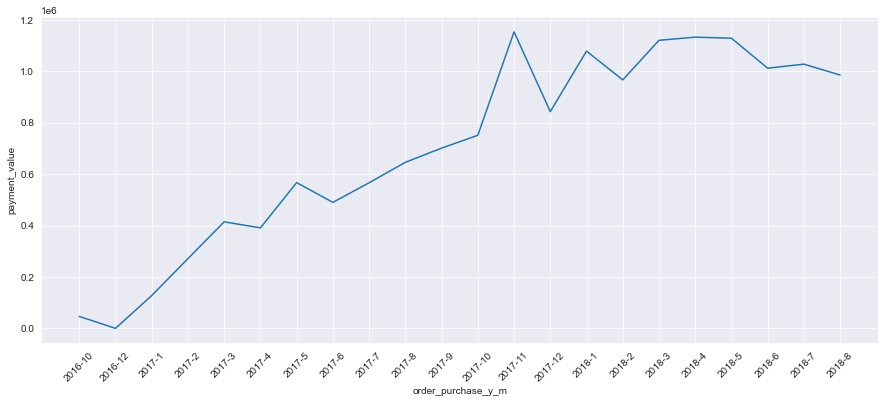

In [97]:
plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
sns.lineplot(data=revenue, x="order_purchase_y_m", y="payment_value")
plt.xticks(rotation=45)

消費人數、人均訂單數、客單價